In [ ]:
# In this project, we will implement a linear SVM and one operating in kernel space. We will be using cvxpy
# and its quadratic programming solver. 

In [1]:
# Import the necessary libraries
import numpy as np
import os
import sys
import traceback
import time
from cvxpy import *
from scipy.spatial.distance import cdist
from visclassifier import visclassifier
import matplotlib
import matplotlib.pyplot as plt

from scipy.stats import linregress

import pylab
from matplotlib.animation import FuncAnimation

%matplotlib notebook

In [2]:
# Generate random data
def genrandomdata(n=100,b=0.):
    # generate random data and linearly separagle labels
    xTr = np.random.randn(n, 2)
    # defining random hyperplane
    w0 = np.random.rand(2, 1)
    # assigning labels +1, -1 labels depending on what side of the plane they lie on
    yTr = np.sign(np.dot(xTr, w0)+b).flatten()
    return xTr, yTr

<IPython.core.display.Javascript object>


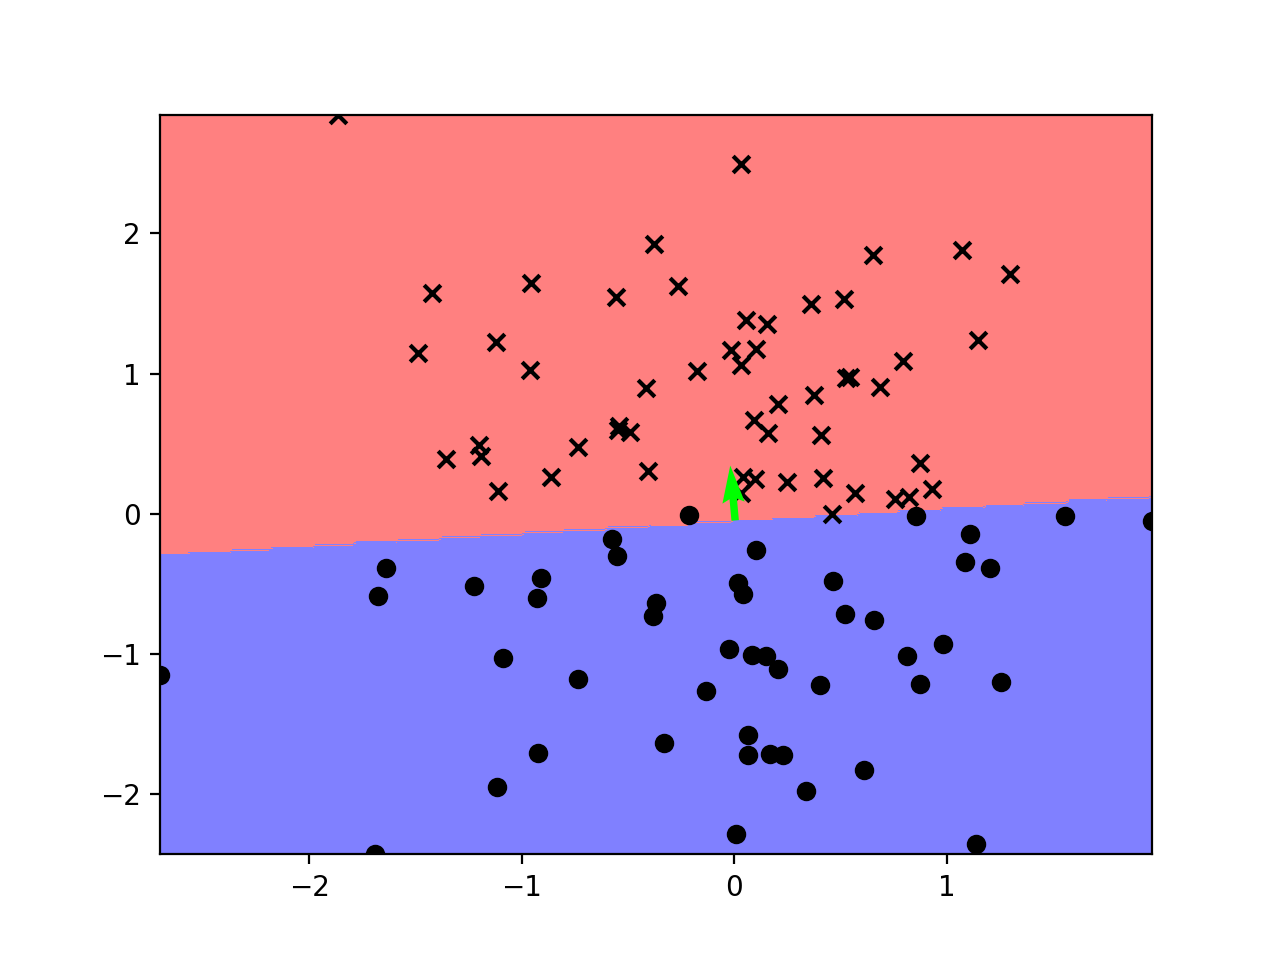

Training error: 1.0%


In [3]:
# Implement a linear SVM
def primalSVM(xTr, yTr, C=1):
    """
    constructs the SVM primal formulation and uses a built-in 
    convex solver to find the optimal solution. 
    Output:
        fun   | usage: predictions=fun(xTe); predictions.shape = (n,)
        wout  | the weight vector calculated by the solver
        bout  | the bias term calculated by the solver
    """
    N, d = xTr.shape
    y = yTr.flatten()
    w = Variable(d)
    b = Variable(1)
    h_x = xTr@w + b
    slack = Variable(N)
    objective = sum_squares(w) + C * sum(slack)
    constraints = [multiply(yTr, h_x)>=1-slack, slack>=0]
    prob = Problem(Minimize(objective), constraints)
    prob.solve()
    wout = w.value
    bout = b.value
    fun = lambda x: x.dot(wout) + bout
    return fun, wout, bout
def arrayify(x):
    return np.array(x).flatten() # flattens and converts to numpy

xTr,yTr=genrandomdata()
fun,w,b=primalSVM(xTr,yTr,C=10)
visclassifier(fun,xTr,yTr,w=w,b=b)

err=np.mean(arrayify(np.sign(fun(xTr)))!=yTr)
print("Training error: %2.1f%%" % (err*100))

<IPython.core.display.Javascript object>


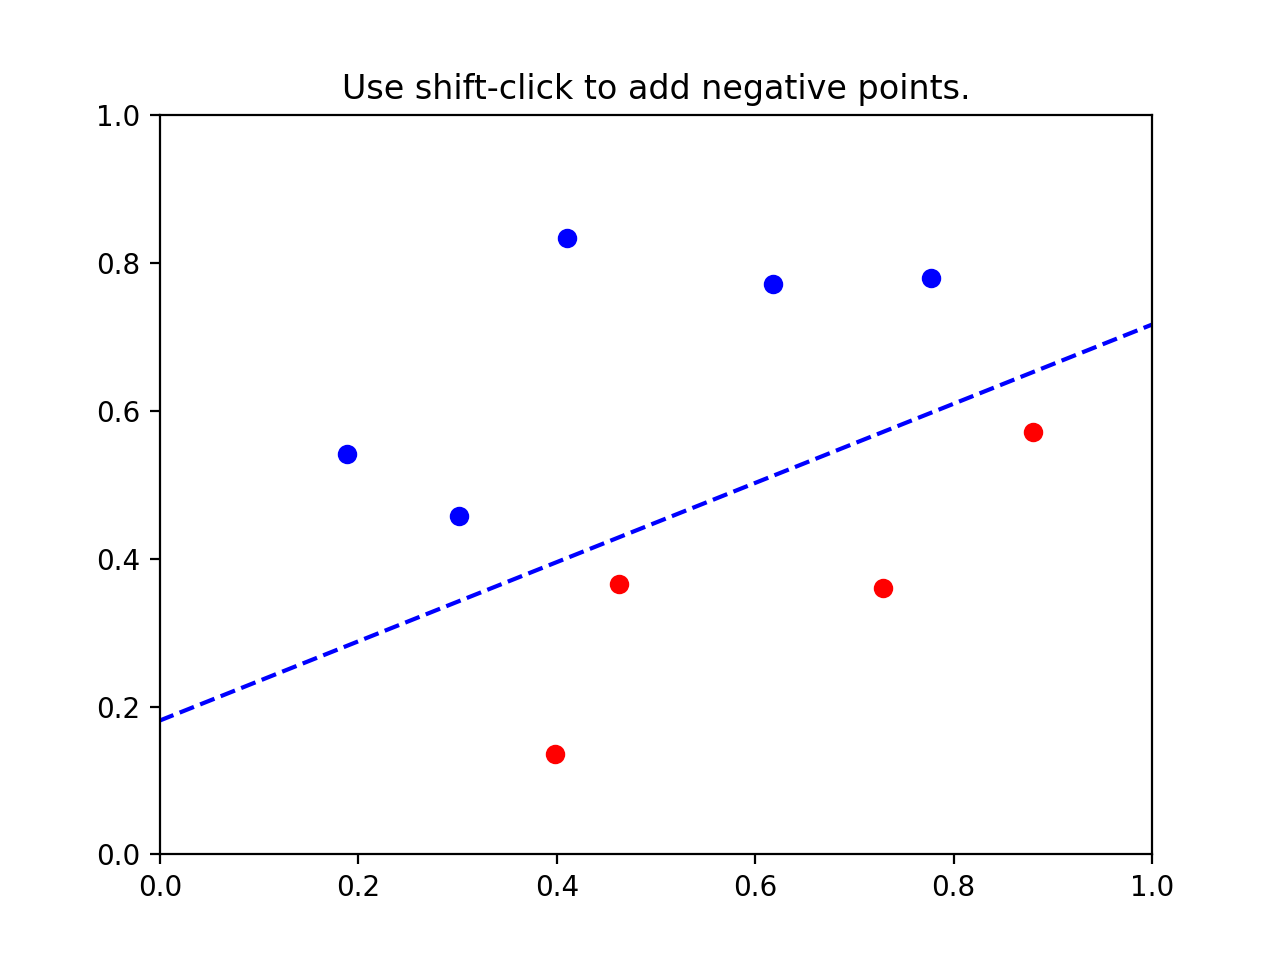

Text(0.5, 1.0, 'Use shift-click to add negative points.')

In [4]:
# Create animation
def updateboundary():
    global w,b,Xdata,ldata,stepsize
    _, w_pre, b_pre = primalSVM(np.transpose(Xdata),np.array(ldata),C=10)
    w = np.array(w_pre).reshape(-1)
    b = b_pre
    stepsize+=1

def updatescreen():
    global w,b,ax,line 
    q=-b/(w**2).sum()*w;
    if line==None:
        line, = ax.plot([q[0]-w[1],q[0]+w[1]],[q[1]+w[0],q[1]-w[0]],'b--')
    else:
        line.set_ydata([q[1]+w[0],q[1]-w[0]])
        line.set_xdata([q[0]-w[1],q[0]+w[1]])
    
def animate(i):
    if (len(ldata)>0) and ((np.min(ldata)+np.max(ldata))==0):
        if stepsize<1000:
            updateboundary()
            updatescreen();
    
def onclick(event):
    global Xdata, stepsize  
    if event.key == 'shift': # add positive point
        ax.plot(event.xdata,event.ydata,'or')
        label=1
    else: # add negative point
        ax.plot(event.xdata,event.ydata,'ob')
        label=-1    
    pos=np.array([[event.xdata],[event.ydata]])
    ldata.append(label);
    Xdata=np.hstack((Xdata,pos))
    stepsize=1;

Xdata=np.random.rand(2,0)
ldata=[]
w=[]
b=[]
line=None
stepsize=1;
fig = plt.figure()
ax = fig.add_subplot(111)
plt.xlim(0,1)
plt.ylim(0,1)
cid = fig.canvas.mpl_connect('button_press_event', onclick)
ani = FuncAnimation(fig, animate,np.arange(1,100,1),interval=10);
plt.title('Use shift-click to add negative points.')

In [ ]:
# If the data is non-linear, this classifier no longer works. Therefore, we generate a spiral dataset to test this
# and to implement a non-linear kernelized SVM classifier. 

<IPython.core.display.Javascript object>


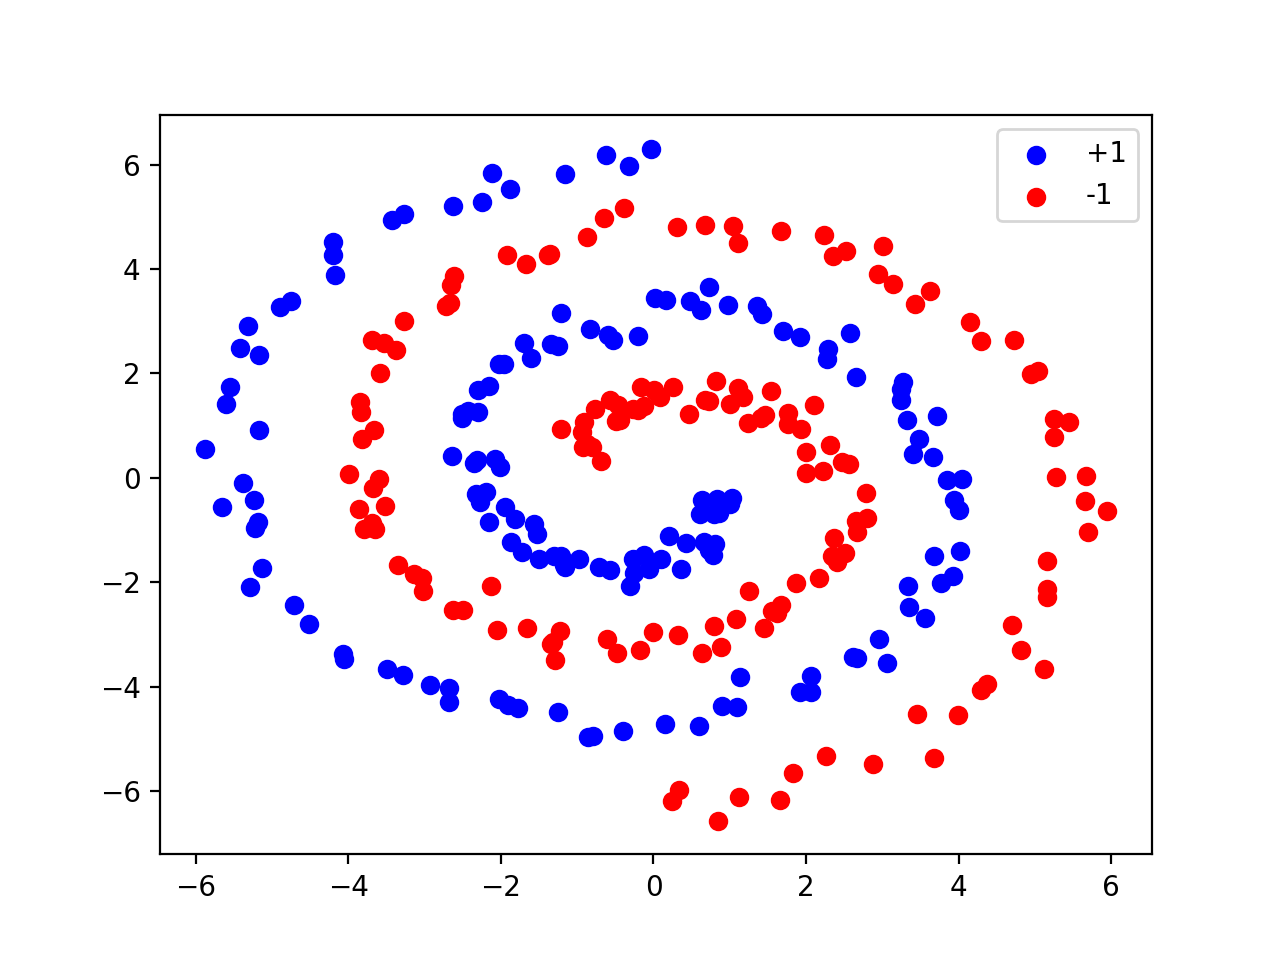

<IPython.core.display.Javascript object>


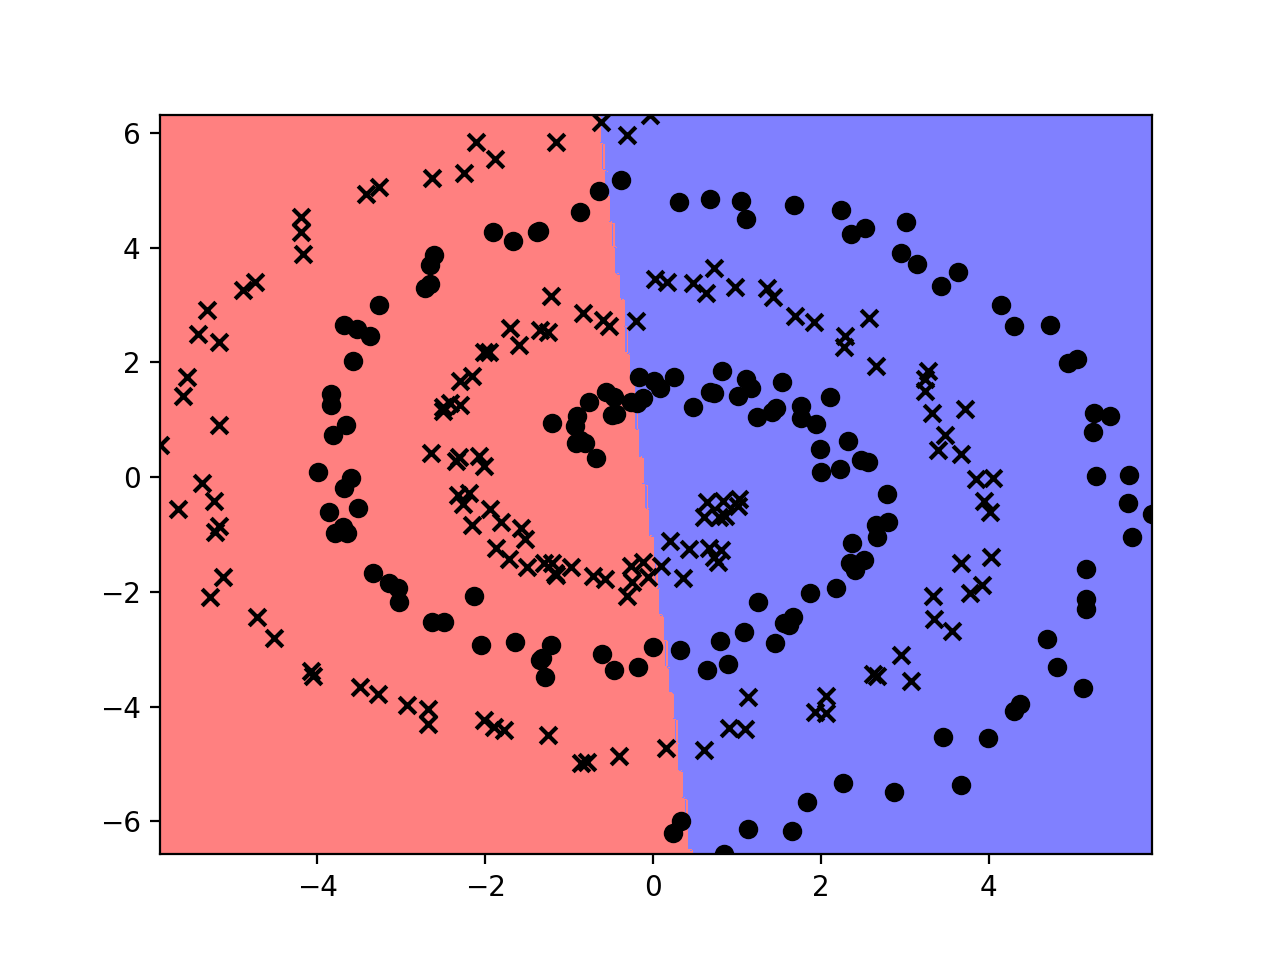

Training error: 40.7%


In [5]:
def spiraldata(N=300):
    r = np.linspace(1,2*np.pi,N)
    xTr1 = np.array([np.sin(2.*r)*r, np.cos(2*r)*r]).T
    xTr2 = np.array([np.sin(2.*r+np.pi)*r, np.cos(2*r+np.pi)*r]).T
    xTr = np.concatenate([xTr1, xTr2], axis=0)
    yTr = np.concatenate([np.ones(N), -1 * np.ones(N)])
    xTr = xTr + np.random.randn(xTr.shape[0], xTr.shape[1])*0.2
    
    xTe = xTr[::2,:]
    yTe = yTr[::2]
    xTr = xTr[1::2,:]
    yTr = yTr[1::2]
    
    return xTr,yTr,xTe,yTe
xTr,yTr,xTe,yTe=spiraldata()
fig = plt.figure()
plt.scatter(xTr[yTr == 1, 0], xTr[yTr == 1, 1], c='b')
plt.scatter(xTr[yTr != 1, 0], xTr[yTr != 1, 1], c='r')
plt.legend(["+1","-1"])
plt.show()

fun,w,b=primalSVM(xTr,yTr,C=0.01)
visclassifier(fun,xTr,yTr,w=[],b=0)
err=np.mean(arrayify(np.sign(fun(xTr)))!=yTr)
print("Training error: %2.1f%%" % (err*100))

<IPython.core.display.Javascript object>


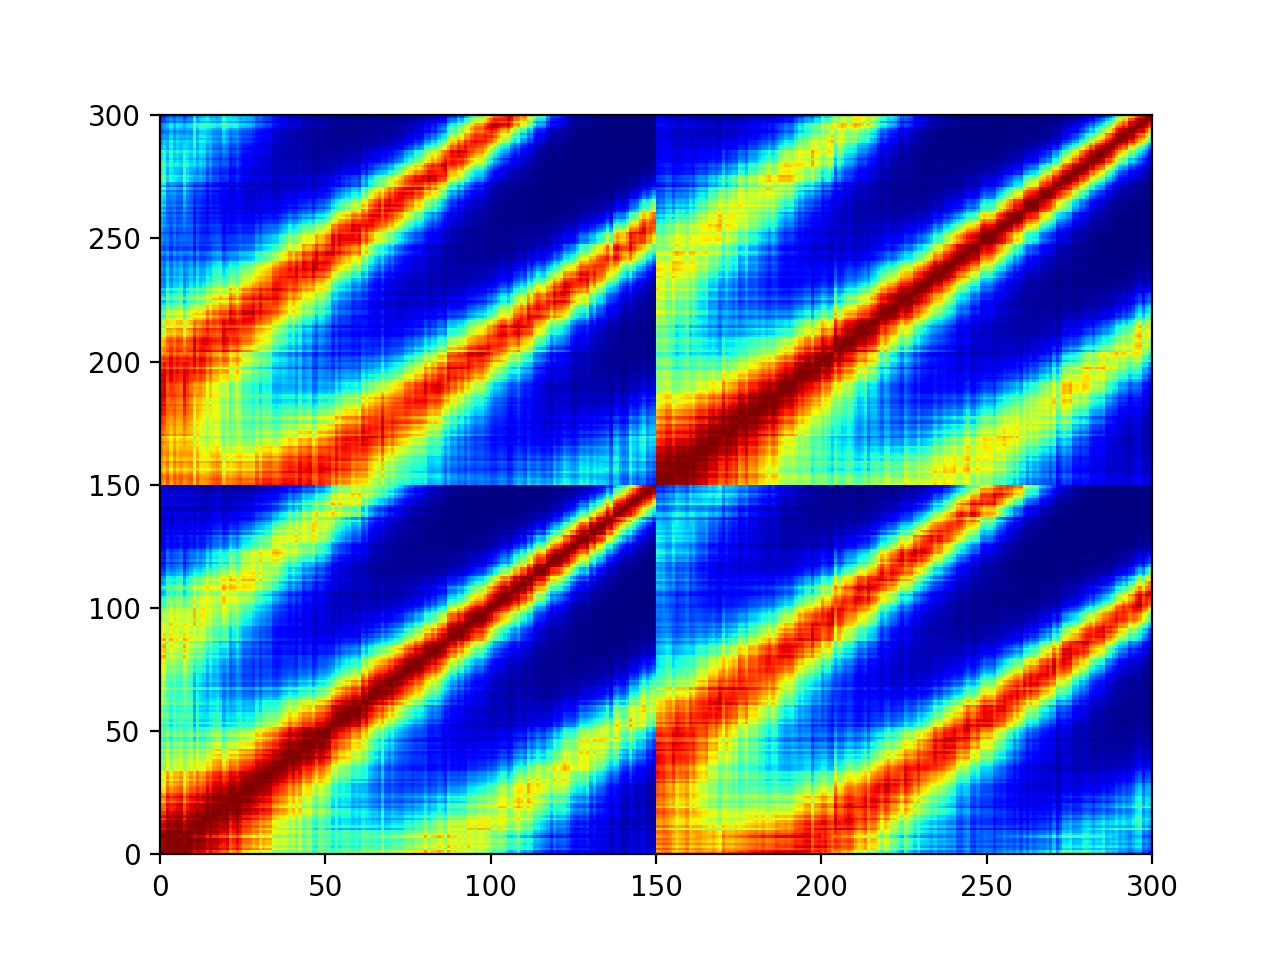

In [6]:
# Implement a kernelized SVM
def computeK(kerneltype, X, Z, kpar=0):
    """
    function K = computeK(kernel_type, X, Z)
    computes a matrix K such that K[i,j]=k(x,z);
    for three different function types: linear, rbf or polynomial.
    
    OUTPUT:
    K : kernel matrix
    """
    assert kerneltype in ["linear","polynomial","poly","rbf"], "Kernel type %s not known." % kerneltype
    assert X.shape[1] == Z.shape[1], "Input dimensions do not match"

    if kerneltype == "linear":
        K = X @ Z.T
    elif kerneltype == "polynomial" or kerneltype == "poly":
        K = (X@Z.T + 1)**kpar
    elif kerneltype == "rbf":
        K = np.exp(-kpar * cdist(X, Z, 'sqeuclidean'))
    
    
    return K

# Test the function by displaying an image of the kernel matrix:
xTr,yTr,xTe,yTe=spiraldata()
K=computeK("rbf",xTr,xTr,kpar=0.05)
# plot an image of the kernel matrix
fig = plt.figure()
plt.pcolormesh(K, cmap='jet')
plt.show()

In [8]:
# Additional testing:
def isClose(num1,num2,numtol=1e-3):
    return np.abs(num1-num2)<numtol

def isMatClose(X1,X2,tol=1e-3):
    a,b = X1.shape
    output = True
    for i in range(a):
        for j in range(b):
            output = output and isClose(X1[i][j],X2[i][j],numtol=tol)
    return output 

def testCase_computeK_linear():
    X = np.array([[9],[0]])
    Z = np.array([[1],[3]])
    K = computeK('linear',X,Z)
    K = np.array(K)
    check = isMatClose(K,np.array([[9,27],[0,0]])) 
    return check

print('computeK passes test for linear kernel: ' + str(testCase_computeK_linear()))

computeK passes test for linear kernel: True


In [9]:
# Solve the dual optimization problem
def dualqp(K,yTr,C):
    """
    function alpha = dualqp(K,yTr,C)
    constructs the SVM dual formulation and uses a built-in 
    convex solver to find the optimal solution. 
    
    Output:
        alpha | the calculated solution vector
    """
    y = yTr.flatten()
    N, _ = K.shape
    alpha = Variable(N)

    #Based on this example: https://www.cvxpy.org/examples/basic/quadratic_program.html, where in the objective formula:
    #x = alpha * y , P = K and the second term is a sum over all alphas
    mul = multiply(alpha, y)
    objective = 1/2 * quad_form(mul, K) - sum(alpha)
    constraints = [0<=alpha, alpha <= C, sum(multiply(alpha, y)) == 0]
    prob = Problem(Minimize(objective), constraints)
    prob.solve()
    return np.array(alpha.value).flatten()

C = 10
lmbda = 0.25
ktype = "rbf"
xTr,yTr,xTe,yTe=spiraldata()
# compute kernel 
K = computeK(ktype,xTr,xTr)
eps = 1e-9
# make sure it is symmetric and positive semi-definite
K = (K + K.T) / 2 + eps * np.eye(K.shape[0])

alpha=dualqp(K,yTr,C)

In [10]:
# Test the implementation of alpha: points that correspond to low K's in the kernelization matrix, are further 
# away from the decision boundary, therefore they are not SVMs are should have alphas 0/ close to 0. Thus, 
# what I am creating below is a training set with these points and calculating alphas on that set. We observe that all
# values of alpha are extremely small, therefore conclude that the computation of alpha is correct. 

C = 10
xTr,yTr,xTe,yTe=spiraldata()
K=computeK("rbf",xTr,xTr,kpar=0.05)
n, m = K.shape
x_train = []
y_train = []

for i in range(n):
    for j in range(m):
        if isClose(K[i, j],0,numtol=1e-3):
            x_train.append(xTr[i, :])
            y_train.append(yTr[i])
x_train = np.array(x_train)
y_train = np.array(y_train)

eps = 1e-9
K_new = computeK("rbf", x_train, x_train, kpar=0.05)
# make sure it is symmetric and positive semi-definite
K_new = (K_new + K_new.T) / 2 + eps * np.eye(K_new.shape[0])

alpha=dualqp(K_new,y_train,C)
print(alpha)

[ 4.23517643e-01  4.23517644e-01 -1.71090508e-21 -8.63559905e-24
 -8.63559899e-24  5.53193256e-22  3.31148651e-22  1.09104046e-22
 -6.72396230e-22 -6.72396230e-22 -8.94440835e-22 -6.72396230e-22
 -6.72396230e-22 -1.01735348e-21 -1.01735348e-21 -4.77027331e-22
  5.02564708e-22  5.02564708e-22  2.80520103e-22  5.84754981e-23
 -1.63569107e-22 -3.85613712e-22 -6.07658317e-22 -8.29702922e-22
 -1.05174753e-21  1.92992359e-02  1.92992358e-02  1.92992356e-02
  1.92992356e-02  1.92992356e-02  1.92992357e-02  1.92992357e-02
  1.92992357e-02  1.92992350e-02  1.92992349e-02  1.92992350e-02
  1.92992350e-02  1.92992350e-02  1.92992350e-02  1.37849269e-21
  1.60053729e-21  1.82258190e-21  1.82258190e-21  1.82258190e-21
  1.82258190e-21  2.04462650e-21  2.26667111e-21  2.26667111e-21
  2.26667111e-21  2.48871571e-21  3.35730612e-22  3.35730612e-22
  3.35730612e-22  1.13686007e-22  1.13686006e-22  1.13686006e-22
  3.35730612e-22  3.35730612e-22  1.13686007e-22  1.13686006e-22
  1.13686007e-22  1.13686

In [12]:
# To correctly classify new test points, we need to calculate the values for b, the bias. 
def recoverBias(K,yTr,alpha,C):
    """
    function bias=recoverBias(K,yTr,alpha,C);
    Solves for the hyperplane bias term, which is uniquely specified by the 
    support vectors with alpha values 0<alpha<C
    
    Output:
    bias : the scalar hyperplane bias of the kernel SVM specified by alphas
    """

    y = yTr.flatten()
    N, _ = K.shape
    half = (C - 0)/2 #calculate the half-point between 0 and C (i.e. the furthest from both 0 and C)
    dist = np.abs(alpha - half) #calculate the distance between alpha and the half-point
    i = np.argmin(dist) #find the alpha that minimizes that distance
    
    bias = y[i] - (y*alpha)@ K[i]
    
    return bias


<IPython.core.display.Javascript object>


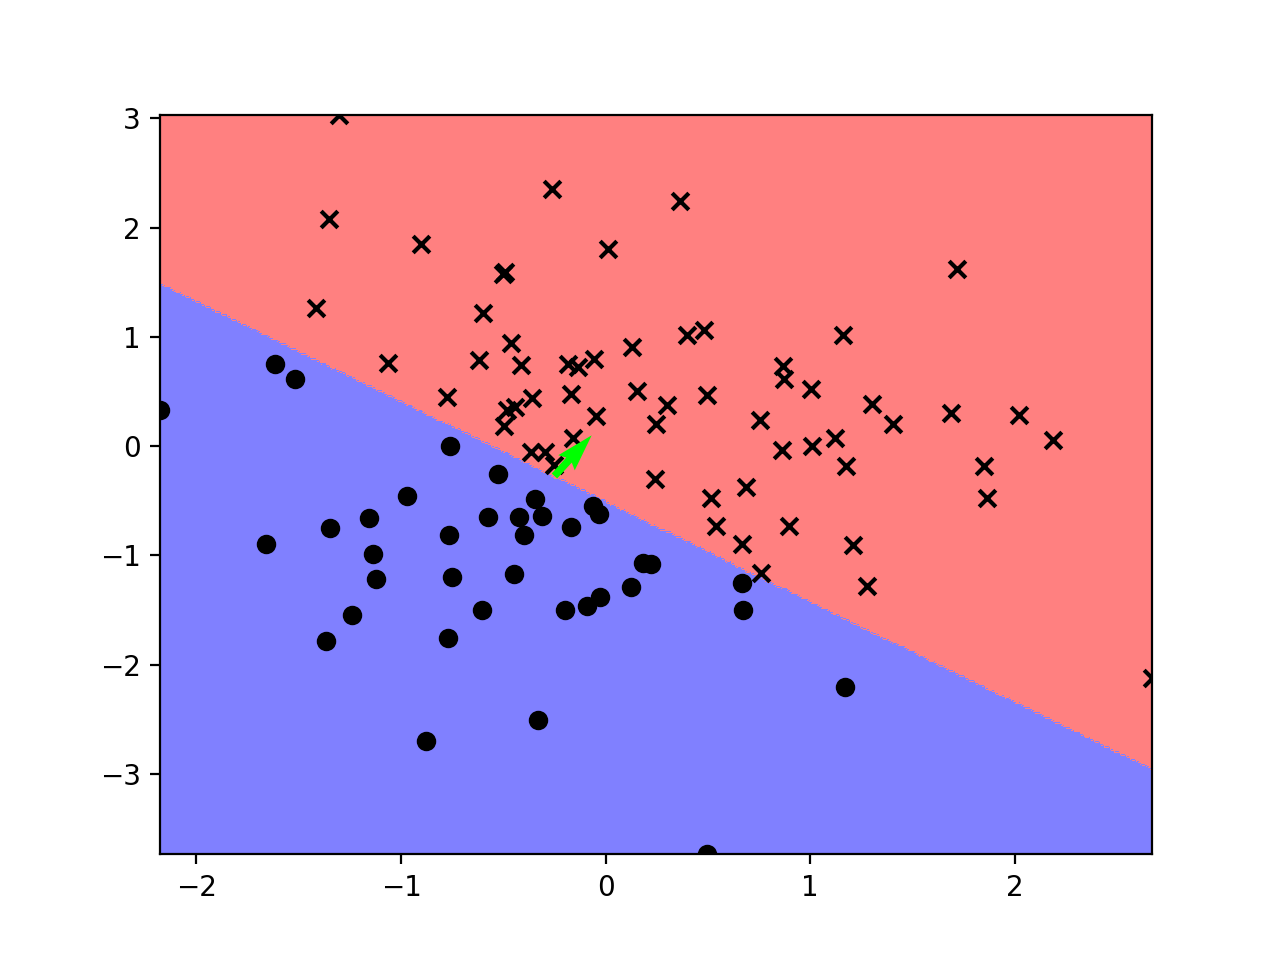

In [13]:
# Test the recoverBias function on the linear dataset
xTr,yTr=genrandomdata(b=0.5)
C=1
K=computeK("linear",xTr,xTr)
eps=1e-10
K = (K + K.T) / 2 + eps * np.eye(K.shape[0])
alpha = dualqp(K,yTr,C)
ba=recoverBias(K,yTr,alpha,C)
wa = (alpha * yTr).dot(xTr)
fun = lambda x: x.dot(wa) + ba
visclassifier(fun, xTr, yTr, w=wa, b=ba)

In [15]:
# Implement the non-linear classification 
def dualSVM(xTr,yTr,C,ktype,lmbda,eps=1e-10):
    """
    function classifier = dualSVM(xTr,yTr,C,ktype,lmbda);
    Constructs the SVM dual formulation and uses a built-in 
    convex solver to find the optimal solution. 
    
    Output:
        svmclassify | usage: predictions=svmclassify(xTe);
    """
    svmclassify = lambda x: (yTr*alpha)@ computeK(ktype, xTr, x, lmbda)  + b

    K = computeK(ktype, xTr, xTr, lmbda)
    K = (K + K.T) / 2 + eps * np.eye(K.shape[0])
    alpha = dualqp(K, yTr, C)
    b = recoverBias(K,yTr,alpha,C)    
    
    return svmclassify

<IPython.core.display.Javascript object>


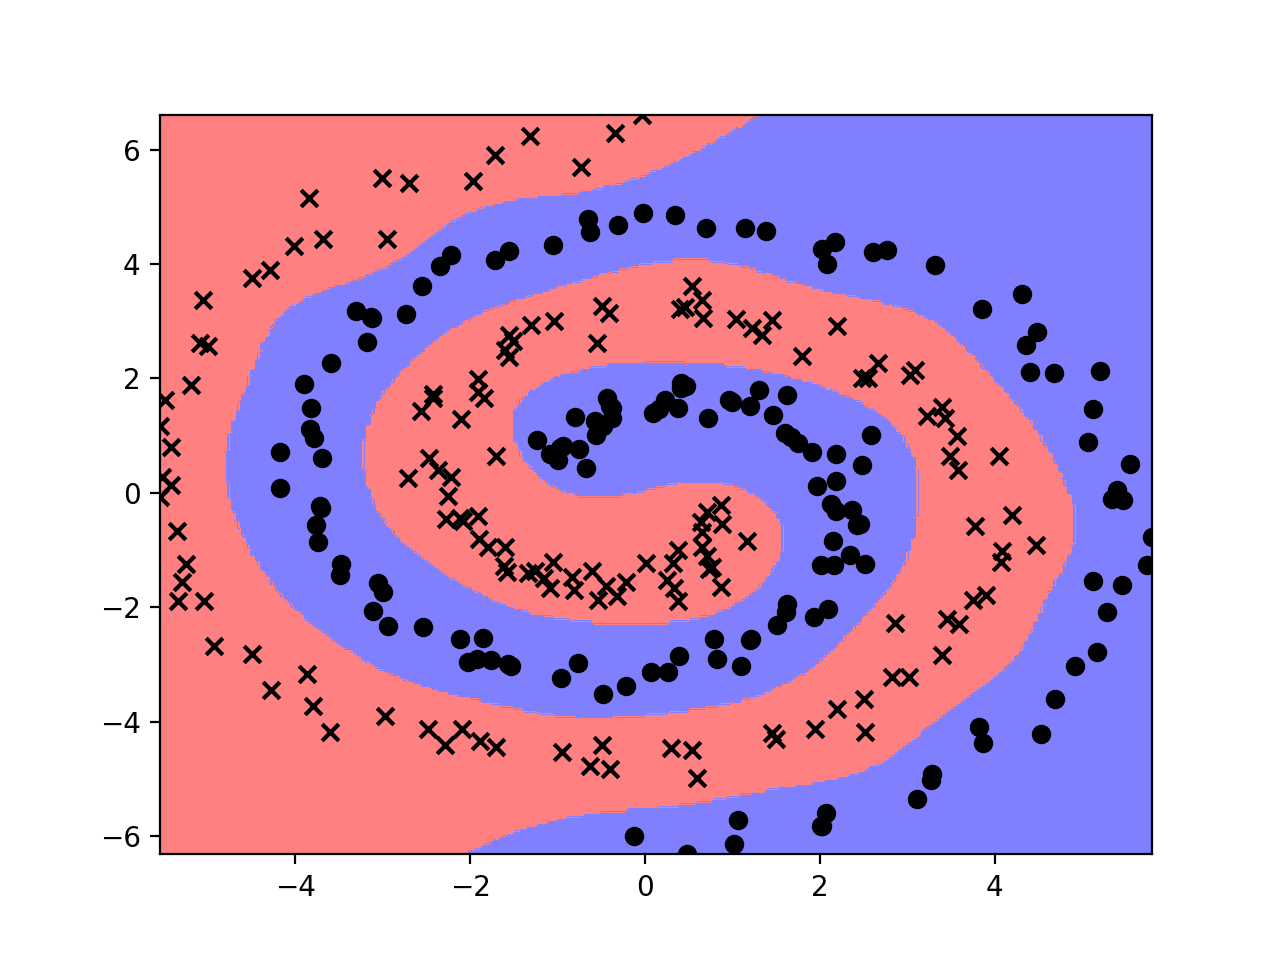

Training error: 0.0000
Testing error: 0.0000


In [16]:
# Test the non-linear classification on the spiral dataset
xTr,yTr,xTe,yTe=spiraldata()
C=10.0
sigma=0.5
ktype="rbf"
svmclassify=dualSVM(xTr,yTr,C,ktype,sigma)

visclassifier(svmclassify,xTr,yTr)

# compute training and testing error
predsTr=svmclassify(xTr)
trainingerr=np.mean(np.sign(predsTr)!=yTr)
print("Training error: %2.4f" % trainingerr)

predsTe=svmclassify(xTe)
testingerr=np.mean(np.sign(predsTe)!=yTe)
print("Testing error: %2.4f" % testingerr)

In [17]:
# SVMs are very sensitive to hyperparameters, and therefore hyperparameter tuning is an important task - we can 
# visualize the search using a heatmap to determine the values of C and lambda that generate the lowest test error. 
def cross_validation(xTr,yTr,xValid,yValid,ktype,CList,lmbdaList):
    """
    function bestC,bestLmbda,ErrorMatrix = cross_validation(xTr,yTr,xValid,yValid,ktype,CList,lmbdaList);
    Use the parameter search to find the optimal parameter,
    Individual models are trained on (xTr,yTr) and validated on (xValid,yValid)
 
    Output:
        bestC      | the best C parameter
        bestLmbda  | the best Lmbda parameter
        ErrorMatrix| the test error rate for each given C and Lmbda when trained on (xTr,yTr) and tested on (xValid,yValid),(axb)
    """
    # gridsearch for best parameters
    ErrorMatrix=np.zeros((len(CList),len(lmbdaList)))
    bestC,bestLmbda = 0.,0.

    for i in range(len(CList)):
        for j in range(len(lmbdaList)):
            svmclassify = dualSVM(xTr,yTr,CList[i],ktype,lmbdaList[j],eps=1e-10)
            prediction = svmclassify(xValid)
            ErrorMatrix[i, j] = np.mean(np.sign(prediction)!=yValid) 
    min_error = np.argwhere(ErrorMatrix == np.min(ErrorMatrix))
    i = min_error[0, 0]
    j = min_error[0, 1]
    bestC = CList[i]
    bestLmbda = lmbdaList[j]
    return bestC,bestLmbda,ErrorMatrix

<IPython.core.display.Javascript object>


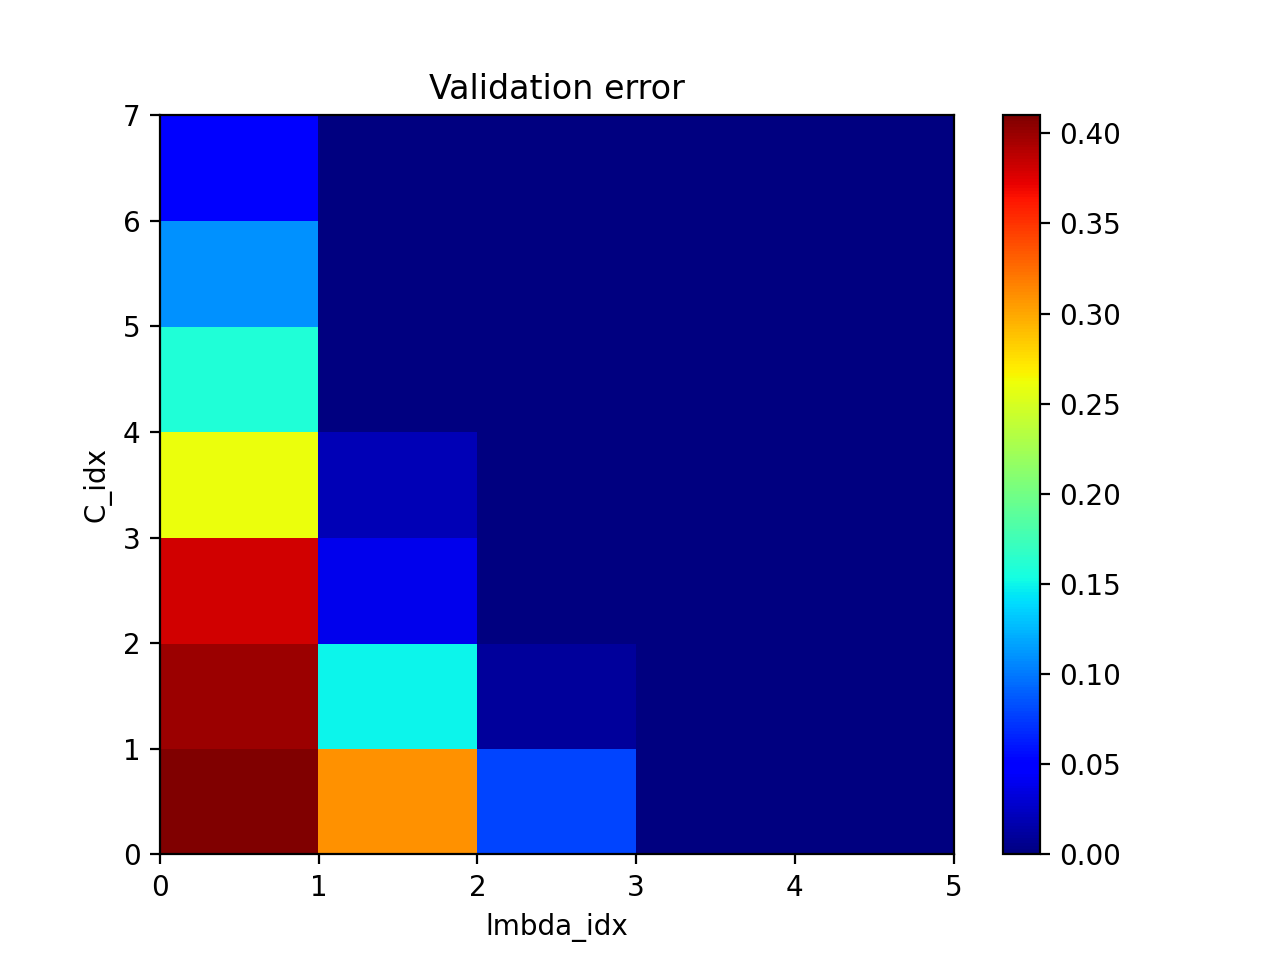

Text(0.5, 1.0, 'Validation error')

In [18]:
# We can visualize this grid search as follows
np.random.seed(15)
xTr,yTr,xValid,yValid=spiraldata(100)
CList=(2.0**np.linspace(-1,5,7))
lmbdaList=(np.linspace(0.1,0.5,5))

bestC,bestLmbda,ErrorMatrix = cross_validation(xTr,yTr,xValid,yValid,'rbf',CList,lmbdaList)
fig = plt.figure()
plt.pcolormesh(ErrorMatrix, cmap='jet')
plt.colorbar()
plt.xlabel("lmbda_idx")
plt.ylabel("C_idx")
plt.title("Validation error")